In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd gdrive/MyDrive/cs334/data/

/content/gdrive/.shortcut-targets-by-id/1lUGmQqyiSFFVjII-tNU4h19MMtxJ0afZ/cs334/data


In [ ]:
!ls

july.csv  may.csv	    xTest.csv	yTest.csv
june.csv  pipelines.joblib  xTrain.csv	yTrain.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
xTrain = pd.read_csv('xTrain.csv')
xTest = pd.read_csv('xTest.csv')
yTrain = pd.read_csv('yTrain.csv')
yTest = pd.read_csv('yTest.csv')

In [53]:
xTrain.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,DISTANCE,OP_UNIQUE_CARRIER_COUNT,ORIGIN_COUNT,ORIGIN_STATE_ABR_COUNT,DEST_COUNT,DEST_STATE_ABR_COUNT,DAY_OF_MONTH_COUNT,DAY_OF_WEEK_COUNT,DEP_TIME
0,25,5,AS,SEA,WA,LAS,NV,764,867.0,33443,31081,37326,25237,29353,35393,159138,12-18
1,22,2,AA,TPA,FL,PHL,PA,1037,920.0,133648,11568,101143,15659,24236,34839,142857,12-18
2,2,5,WN,SDF,KY,RSW,FL,835,835.0,189831,3389,10368,6488,100895,33559,159138,12-18
3,14,1,AA,CLT,NC,BDL,CT,440,644.0,133648,36698,50388,3563,3619,35783,155277,6-12
4,7,3,WN,MEM,TN,ATL,GA,810,332.0,189831,3466,20443,55493,60531,35209,146538,12-18


In [ ]:
%cd ../models

/content/gdrive/.shortcut-targets-by-id/1lUGmQqyiSFFVjII-tNU4h19MMtxJ0afZ/cs334/models


In [ ]:
# when read, these become int again, thus need mapping
xTrain['DAY_OF_MONTH'] = xTrain['DAY_OF_MONTH'].map(lambda x: str(x))
xTrain['DAY_OF_WEEK'] = xTrain['DAY_OF_WEEK'].map(lambda x: str(x))
xTest['DAY_OF_MONTH'] = xTest['DAY_OF_MONTH'].map(lambda x: str(x))
xTest['DAY_OF_WEEK'] = xTest['DAY_OF_WEEK'].map(lambda x: str(x))

In [ ]:
!pip install ConfigSpace

     |████████████████████████████████| 4.2 MB 5.0 MB/s 


In [ ]:
# attempt with pipeline
import category_encoders
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders.m_estimate import MEstimateEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, fbeta_score, plot_roc_curve, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
import scipy 
from ray import tune
from tune_sklearn import TuneSearchCV
import joblib
from ray.util.joblib import register_ray
from joblib import dump, load
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
xTrain.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,ORIGIN_STATE_ABR,DEST,DEST_STATE_ABR,CRS_DEP_TIME,DISTANCE,OP_UNIQUE_CARRIER_COUNT,ORIGIN_COUNT,ORIGIN_STATE_ABR_COUNT,DEST_COUNT,DEST_STATE_ABR_COUNT,DAY_OF_MONTH_COUNT,DAY_OF_WEEK_COUNT
0,25,5,AS,SEA,WA,LAS,NV,764,867.0,33443,31081,37326,25237,29353,35393,159138
1,22,2,AA,TPA,FL,PHL,PA,1037,920.0,133648,11568,101143,15659,24236,34839,142857
2,2,5,WN,SDF,KY,RSW,FL,835,835.0,189831,3389,10368,6488,100895,33559,159138
3,14,1,AA,CLT,NC,BDL,CT,440,644.0,133648,36698,50388,3563,3619,35783,155277
4,7,3,WN,MEM,TN,ATL,GA,810,332.0,189831,3466,20443,55493,60531,35209,146538


In [ ]:
xTrain1 = xTrain[['CRS_DEP_TIME','DISTANCE','OP_UNIQUE_CARRIER_COUNT','ORIGIN_COUNT','ORIGIN_STATE_ABR_COUNT','DEST_COUNT','DEST_STATE_ABR_COUNT','DAY_OF_WEEK_COUNT']]
xTest1 = xTest[['CRS_DEP_TIME','DISTANCE','OP_UNIQUE_CARRIER_COUNT','ORIGIN_COUNT','ORIGIN_STATE_ABR_COUNT','DEST_COUNT','DEST_STATE_ABR_COUNT','DAY_OF_WEEK_COUNT']]

In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
lg = LogisticRegression()

# fit the model with data
lg.fit(xTrain1,yTrain['DEP_DEL15'])

#
y_pred=lg.predict(xTest1)

In [ ]:
# import the metrics class
from sklearn import metrics
lg_matrix = metrics.confusion_matrix(yTest['DEP_DEL15'], y_pred)
lg_matrix

array([[414115,    815],
       [112191,    663]])

In [51]:
matrix_past = np.array([[1396704,288457],[45589,38269]])
matrix_past

array([[1396704,  288457],
       [  45589,   38269]])

Text(0.5, 257.44, 'Predicted label')

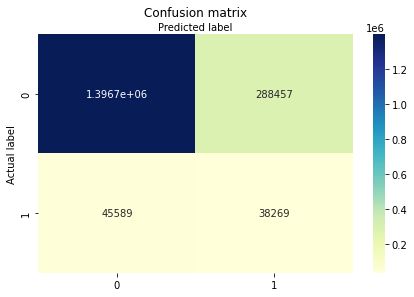

In [52]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix_past), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 257.44, 'Predicted label')

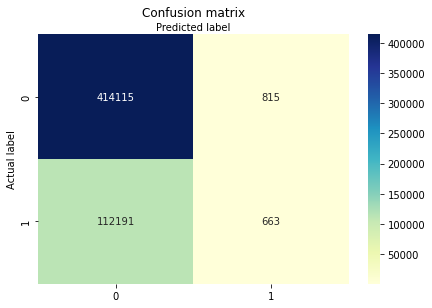

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(lg_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
# create a list of our conditions
conditions = [
    (xTrain['CRS_DEP_TIME'] <= 360),
    (xTrain['CRS_DEP_TIME'] > 360) & (xTrain['CRS_DEP_TIME'] <= 720),
    (xTrain['CRS_DEP_TIME'] > 720) & (xTrain['CRS_DEP_TIME'] <= 1080),
    (xTrain['CRS_DEP_TIME'] > 1080)
    ]

# create a list of the values we want to assign for each condition
values = ['0-6', '6-12', '12-18', '18-24']

# create a new column and use np.select to assign values to it using our lists as arguments
xTrain['DEP_TIME'] = np.select(conditions, values)

In [ ]:
# create a list of our conditions
conditions = [
    (xTest['CRS_DEP_TIME'] <= 360),
    (xTest['CRS_DEP_TIME'] > 360) & (xTest['CRS_DEP_TIME'] <= 720),
    (xTest['CRS_DEP_TIME'] > 720) & (xTest['CRS_DEP_TIME'] <= 1080),
    (xTest['CRS_DEP_TIME'] > 1080)
    ]

# create a list of the values we want to assign for each condition
values = ['0-6', '6-12', '12-18', '18-24']

# create a new column and use np.select to assign values to it using our lists as arguments
xTest['DEP_TIME'] = np.select(conditions, values)

In [ ]:
# Carrier Distribution
time_count = xTrain.groupby("DEP_TIME").size()
time_count

DEP_TIME
0-6       42984
12-18    383835
18-24    233149
6-12     411593
dtype: int64

In [ ]:
xTrain1 = xTrain[['DISTANCE','DAY_OF_WEEK','OP_UNIQUE_CARRIER','ORIGIN_STATE_ABR','DEST_STATE_ABR','DEP_TIME']]
xTest1 = xTest[['DISTANCE','DAY_OF_WEEK','OP_UNIQUE_CARRIER','ORIGIN_STATE_ABR','DEST_STATE_ABR','DEP_TIME']]
xTrain1.head()

,DISTANCE,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN_STATE_ABR,DEST_STATE_ABR,DEP_TIME
0,867.0,5,AS,WA,NV,12-18
1,920.0,2,AA,FL,PA,12-18
2,835.0,5,WN,KY,FL,12-18
3,644.0,1,AA,NC,CT,6-12
4,332.0,3,WN,TN,GA,12-18


In [ ]:
xTrain1['DAY_OF_WEEK'] = xTrain1['DAY_OF_WEEK'].apply(str)
xTest1['DAY_OF_WEEK'] = xTest1['DAY_OF_WEEK'].apply(str)
xTrain1.dtypes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


DISTANCE             float64
DAY_OF_WEEK           object
OP_UNIQUE_CARRIER     object
ORIGIN_STATE_ABR      object
DEST_STATE_ABR        object
DEP_TIME              object
dtype: object

In [ ]:
yTrain1 = yTrain[['DEP_DEL15']]
yTest1 = yTest[['DEP_DEL15']]
yTrain1.head()

,DEP_DEL15
0,0.0
1,1.0
2,1.0
3,0.0
4,1.0


In [ ]:
# One-hot encode the data using pandas get_dummies
xTrain2 = pd.get_dummies(xTrain1)
xTest2 = pd.get_dummies(xTest1)
xTrain2.head()

,DISTANCE,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_AA,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_F9,OP_UNIQUE_CARRIER_G4,OP_UNIQUE_CARRIER_HA,OP_UNIQUE_CARRIER_MQ,OP_UNIQUE_CARRIER_NK,OP_UNIQUE_CARRIER_OH,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_QX,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,OP_UNIQUE_CARRIER_YV,OP_UNIQUE_CARRIER_YX,ORIGIN_STATE_ABR_AK,ORIGIN_STATE_ABR_AL,ORIGIN_STATE_ABR_AR,ORIGIN_STATE_ABR_AZ,ORIGIN_STATE_ABR_CA,ORIGIN_STATE_ABR_CO,ORIGIN_STATE_ABR_CT,ORIGIN_STATE_ABR_DE,ORIGIN_STATE_ABR_FL,ORIGIN_STATE_ABR_GA,ORIGIN_STATE_ABR_HI,ORIGIN_STATE_ABR_IA,ORIGIN_STATE_ABR_ID,ORIGIN_STATE_ABR_IL,ORIGIN_STATE_ABR_IN,...,DEST_STATE_ABR_LA,DEST_STATE_ABR_MA,DEST_STATE_ABR_MD,DEST_STATE_ABR_ME,DEST_STATE_ABR_MI,DEST_STATE_ABR_MN,DEST_STATE_ABR_MO,DEST_STATE_ABR_MS,DEST_STATE_ABR_MT,DEST_STATE_ABR_NC,DEST_STATE_ABR_ND,DEST_STATE_ABR_NE,DEST_STATE_ABR_NH,DEST_STATE_ABR_NJ,DEST_STATE_ABR_NM,DEST_STATE_ABR_NV,DEST_STATE_ABR_NY,DEST_STATE_ABR_OH,DEST_STATE_ABR_OK,DEST_STATE_ABR_OR,DEST_STATE_ABR_PA,DEST_STATE_ABR_PR,DEST_STATE_ABR_RI,DEST_STATE_ABR_SC,DEST_STATE_ABR_SD,DEST_STATE_ABR_TN,DEST_STATE_ABR_TT,DEST_STATE_ABR_TX,DEST_STATE_ABR_UT,DEST_STATE_ABR_VA,DEST_STATE_ABR_VI,DEST_STATE_ABR_VT,DEST_STATE_ABR_WA,DEST_STATE_ABR_WI,DEST_STATE_ABR_WV,DEST_STATE_ABR_WY,DEP_TIME_0-6,DEP_TIME_12-18,DEP_TIME_18-24,DEP_TIME_6-12
0,867.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,920.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,835.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,644.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,332.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
ss = StandardScaler()

In [ ]:
dist_train = np.array(xTrain2[['DISTANCE']])
dist_test = np.array(xTest2[['DISTANCE']])
dist_train

array([[ 867.],
       [ 920.],
       [ 835.],
       ...,
       [1050.],
       [ 455.],
       [ 404.]])

In [ ]:
dist_train = ss.fit_transform(dist_train)
dist_test = ss.transform(dist_test)
pd.DataFrame(dist_train)

,0
0,0.070210
1,0.159106
2,0.016537
3,-0.303823
4,-0.827135
...,...
1071556,-0.674502
1071557,0.351993
1071558,0.377152
1071559,-0.620829


In [ ]:
xTrain2['DISTANCE'] = pd.DataFrame(dist_train)
xTest2['DISTANCE'] = pd.DataFrame(dist_test)
xTrain2.head()

,DISTANCE,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_AA,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_F9,OP_UNIQUE_CARRIER_G4,OP_UNIQUE_CARRIER_HA,OP_UNIQUE_CARRIER_MQ,OP_UNIQUE_CARRIER_NK,OP_UNIQUE_CARRIER_OH,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_QX,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,OP_UNIQUE_CARRIER_YV,OP_UNIQUE_CARRIER_YX,ORIGIN_STATE_ABR_AK,ORIGIN_STATE_ABR_AL,ORIGIN_STATE_ABR_AR,ORIGIN_STATE_ABR_AZ,ORIGIN_STATE_ABR_CA,ORIGIN_STATE_ABR_CO,ORIGIN_STATE_ABR_CT,ORIGIN_STATE_ABR_DE,ORIGIN_STATE_ABR_FL,ORIGIN_STATE_ABR_GA,ORIGIN_STATE_ABR_HI,ORIGIN_STATE_ABR_IA,ORIGIN_STATE_ABR_ID,ORIGIN_STATE_ABR_IL,ORIGIN_STATE_ABR_IN,...,DEST_STATE_ABR_LA,DEST_STATE_ABR_MA,DEST_STATE_ABR_MD,DEST_STATE_ABR_ME,DEST_STATE_ABR_MI,DEST_STATE_ABR_MN,DEST_STATE_ABR_MO,DEST_STATE_ABR_MS,DEST_STATE_ABR_MT,DEST_STATE_ABR_NC,DEST_STATE_ABR_ND,DEST_STATE_ABR_NE,DEST_STATE_ABR_NH,DEST_STATE_ABR_NJ,DEST_STATE_ABR_NM,DEST_STATE_ABR_NV,DEST_STATE_ABR_NY,DEST_STATE_ABR_OH,DEST_STATE_ABR_OK,DEST_STATE_ABR_OR,DEST_STATE_ABR_PA,DEST_STATE_ABR_PR,DEST_STATE_ABR_RI,DEST_STATE_ABR_SC,DEST_STATE_ABR_SD,DEST_STATE_ABR_TN,DEST_STATE_ABR_TT,DEST_STATE_ABR_TX,DEST_STATE_ABR_UT,DEST_STATE_ABR_VA,DEST_STATE_ABR_VI,DEST_STATE_ABR_VT,DEST_STATE_ABR_WA,DEST_STATE_ABR_WI,DEST_STATE_ABR_WV,DEST_STATE_ABR_WY,DEP_TIME_0-6,DEP_TIME_12-18,DEP_TIME_18-24,DEP_TIME_6-12
0,0.070210,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.159106,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.016537,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,-0.303823,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.827135,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
print(yTrain1.shape, yTest1.shape, xTrain2.shape, xTest2.shape)

(1071561, 1) (527784, 1) (1071561, 135) (527784, 135)


In [ ]:
# Decision Tree model
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(xTrain2,yTrain1)
dtc.score(xTest2,yTest1)

0.7865983053673472

In [44]:
y_true = yTest1
y_pred = dtc.predict(xTest2)
fbeta_score(y_true, y_pred, beta=2)

0.2373879204862295

In [46]:
dtc_up = DecisionTreeClassifier(random_state=42)
dtc_up.fit(xTrain_up32,yTrain_up32)
y_true_up = yTest1
y_pred_up = dtc_up.predict(xTest2)
fbeta_score(y_true_up, y_pred_up, beta=2)

0.438776080429581

In [47]:
print(dtc_up.score(xTest2,yTest1))

0.7189702605611387


In [48]:
lg_up = LogisticRegression(random_state=0)
lg_up.fit(xTrain_up32,yTrain_up32)
y_true_up = yTest1
y_pred_up = lg_up.predict(xTest2)
print(lg_up.score(xTest2,yTest1))
print(fbeta_score(y_true_up, y_pred_up, beta=2))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.7435409182544375
0.4414209984032359


In [49]:
rf_up = RandomForestClassifier()
rf_up.fit(xTrain_up32,yTrain_up32)
y_true_up = yTest1
y_pred_up = rf_up.predict(xTest2)
print(rf_up.score(xTest2,yTest1))
print(fbeta_score(y_true_up, y_pred_up, beta=2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7095440559016567
0.45264433803304666


In [ ]:
pipeline_dt = Pipeline([('dt_classifier',DecisionTreeClassifier(random_state=42))])
pipeline_lr = Pipeline([('lr_classifier',LogisticRegression(random_state=0))])
pipeline_rf = Pipeline([('rf_classifier',RandomForestClassifier())])
# pipeline_kn = Pipeline([('kn_classifier',KNeighborsClassifier(n_neighbors=3))])

In [ ]:
pipelines = [pipeline_dt, pipeline_lr, pipeline_rf]

In [ ]:
pipe_dict = {0: 'Decision Tree', 1: 'Logistic Regression', 2: 'Random Forest'}

In [ ]:
for pipe in pipelines:
  pipe.fit(xTrain2, yTrain1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ra

In [ ]:
y_true = yTest1
for i, model in enumerate(pipelines):
  y_pred = model.predict(xTest2)
  print("{} Test Accuracy: {}".format(pipe_dict[i], model.score(xTest2, yTest1)))
  print("{} F1 Score: {}".format(pipe_dict[i], f1_score(y_true, y_pred)))
  print("{} F-beta Score: {}".format(pipe_dict[i], fbeta_score(y_true, y_pred, beta=2)))

Decision Tree Test Accuracy: 0.7862875721886227
Decision Tree F1 Score: 0.2953633944300761
Decision Tree F-beta Score: 0.2370466632974755
Logistic Regression Test Accuracy: 0.7924037106088855
Logistic Regression F1 Score: 0.13441301943434983
Logistic Regression F-beta Score: 0.09144519308082265
Random Forest Test Accuracy: 0.7826004577630242
Random Forest F1 Score: 0.31997060357498464
Random Forest F-beta Score: 0.2660608330540717


In [ ]:
pipeline_dt_pca = Pipeline([('pca1',PCA(n_components=3)),
                            ('dt_classifier_pca',DecisionTreeClassifier(random_state=42))])
pipeline_lr_pca = Pipeline([('pca2',PCA(n_components=3)),
                        ('lr_classifier_pca',LogisticRegression(random_state=0))])
pipeline_rf_pca = Pipeline([('pca3',PCA(n_components=3)),
                        ('rf_classifier_pca',RandomForestClassifier())])
# pipeline_kn_pca = Pipeline([('pca1',PCA(n_components=3)),
#                         ('kn_classifier',KNeighborsClassifier(n_neighbors=3))])

In [ ]:
pipelines_pca = [pipeline_dt_pca, pipeline_lr_pca, pipeline_rf_pca]

In [ ]:
pipe_dict_pca = {0: 'Decision Tree PCA', 1: 'Logistic Regression PCA', 2: 'Random Forest PCA'}

In [ ]:
for pipe in pipelines_pca:
  pipe.fit(xTrain2, yTrain1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [ ]:
y_true = yTest1
for i, model in enumerate(pipelines_pca):
  y_pred = model.predict(xTest2)
  print("{} Test Accuracy: {}".format(pipe_dict_pca[i], model.score(xTest2, yTest1)))
  print("{} F1 Score: {}".format(pipe_dict_pca[i], f1_score(y_true, y_pred)))
  print("{} F-beta Score: {}".format(pipe_dict_pca[i], fbeta_score(y_true, y_pred, beta=2)))

Decision Tree PCA Test Accuracy: 0.7756525396753218
Decision Tree PCA F1 Score: 0.27055598336670256
Decision Tree PCA F-beta Score: 0.21920113718263803
Logistic Regression PCA Test Accuracy: 0.7861738893183575
Logistic Regression PCA F1 Score: 0.0
Logistic Regression PCA F-beta Score: 0.0
Random Forest PCA Test Accuracy: 0.7898041623088233
Random Forest PCA F1 Score: 0.26470744187279616
Random Forest PCA F-beta Score: 0.2039992808077836


In [ ]:
dump(pipelines, 'pipelines.joblib')

['pipelines.joblib']

In [ ]:
# up down sample
xTrain2_1 = xTrain2[yTrain1['DEP_DEL15'] == 1]
xTrain2_0 = xTrain2[yTrain1['DEP_DEL15'] == 0]
yTrain1_1 = yTrain1[yTrain1['DEP_DEL15'] == 1]
yTrain1_0 = yTrain1[yTrain1['DEP_DEL15'] == 0]
xTrain1_up32, yTrain1_up32 = resample(xTrain2_1, yTrain1_1, n_samples=xTrain2_0.shape[0]*2//3, random_state=42)
xTrain_up32 = pd.concat([xTrain1_up32, xTrain2_0])
yTrain_up32 = pd.concat([yTrain1_up32, yTrain1_0])
xTrain0_down, yTrain0_down = resample(xTrain2_0, yTrain1_0, n_samples=xTrain2_1.shape[0], random_state=42)
xTrain_down = pd.concat([xTrain0_down, xTrain2_1])
yTrain_down = pd.concat([yTrain0_down, yTrain1_1])

In [ ]:
xTrain_up32.head()

,DISTANCE,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,OP_UNIQUE_CARRIER_9E,OP_UNIQUE_CARRIER_AA,OP_UNIQUE_CARRIER_AS,OP_UNIQUE_CARRIER_B6,OP_UNIQUE_CARRIER_DL,OP_UNIQUE_CARRIER_F9,OP_UNIQUE_CARRIER_G4,OP_UNIQUE_CARRIER_HA,OP_UNIQUE_CARRIER_MQ,OP_UNIQUE_CARRIER_NK,OP_UNIQUE_CARRIER_OH,OP_UNIQUE_CARRIER_OO,OP_UNIQUE_CARRIER_QX,OP_UNIQUE_CARRIER_UA,OP_UNIQUE_CARRIER_WN,OP_UNIQUE_CARRIER_YV,OP_UNIQUE_CARRIER_YX,ORIGIN_STATE_ABR_AK,ORIGIN_STATE_ABR_AL,ORIGIN_STATE_ABR_AR,ORIGIN_STATE_ABR_AZ,ORIGIN_STATE_ABR_CA,ORIGIN_STATE_ABR_CO,ORIGIN_STATE_ABR_CT,ORIGIN_STATE_ABR_DE,ORIGIN_STATE_ABR_FL,ORIGIN_STATE_ABR_GA,ORIGIN_STATE_ABR_HI,ORIGIN_STATE_ABR_IA,ORIGIN_STATE_ABR_ID,ORIGIN_STATE_ABR_IL,ORIGIN_STATE_ABR_IN,...,DEST_STATE_ABR_LA,DEST_STATE_ABR_MA,DEST_STATE_ABR_MD,DEST_STATE_ABR_ME,DEST_STATE_ABR_MI,DEST_STATE_ABR_MN,DEST_STATE_ABR_MO,DEST_STATE_ABR_MS,DEST_STATE_ABR_MT,DEST_STATE_ABR_NC,DEST_STATE_ABR_ND,DEST_STATE_ABR_NE,DEST_STATE_ABR_NH,DEST_STATE_ABR_NJ,DEST_STATE_ABR_NM,DEST_STATE_ABR_NV,DEST_STATE_ABR_NY,DEST_STATE_ABR_OH,DEST_STATE_ABR_OK,DEST_STATE_ABR_OR,DEST_STATE_ABR_PA,DEST_STATE_ABR_PR,DEST_STATE_ABR_RI,DEST_STATE_ABR_SC,DEST_STATE_ABR_SD,DEST_STATE_ABR_TN,DEST_STATE_ABR_TT,DEST_STATE_ABR_TX,DEST_STATE_ABR_UT,DEST_STATE_ABR_VA,DEST_STATE_ABR_VI,DEST_STATE_ABR_VT,DEST_STATE_ABR_WA,DEST_STATE_ABR_WI,DEST_STATE_ABR_WV,DEST_STATE_ABR_WY,DEP_TIME_0-6,DEP_TIME_12-18,DEP_TIME_18-24,DEP_TIME_6-12
573024,-0.661084,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
687863,-0.684566,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
618871,0.687449,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
488572,-1.199491,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
563457,0.328511,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
yTrain_up32['DEP_DEL15'].value_counts()

0.0    843165
1.0    562110
Name: DEP_DEL15, dtype: int64

In [ ]:
yTrain_down['DEP_DEL15'].value_counts()

1.0    228396
0.0    228396
Name: DEP_DEL15, dtype: int64

In [ ]:
# create pipeline
# check https://scikit-learn.org/stable/modules/compose.html nested params
pipe = Pipeline([('clf', RandomForestClassifier(random_state=42))])

In [ ]:
# cheat test for what model might be better
# with joblib.parallel_backend('ray'):
pipe.fit(xTrain_up32, yTrain_up32)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('clf', RandomForestClassifier(random_state=42))])

In [ ]:
print(fbeta_score(yTest1, pipe.predict(xTest2), beta=2))
print(accuracy_score(yTest1, pipe.predict(xTest2)))

0.45264968307695896
0.7095232140421082


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


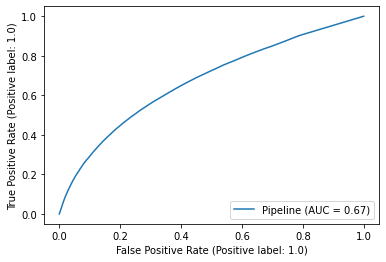

In [ ]:
plot_roc_curve(pipe, xTest2, yTest1)

In [ ]:
# set parameters grid, could also use RandomizedSearchCV (probably better even)
param_dists = {
    # 'me__m': tune.uniform(1,100),
    # 'clf__C': tune.loguniform(1e-3, 1),
    # 'clf__solver': tune.choice(['lbfgs', 'saga', 'newton-cg']),
    # 'clf__warm_start': tune.choice([True, False]),
    # 'clf__max_iter': tune.uniform(100,500)
    # 'clf__n_neighbors': tune.randint(5,500),
    'clf__n_estimators': tune.randint(0,120),
    'clf__criterion': tune.choice(['gini', 'entropy']),
    'clf__max_depth': tune.choice([None, tune.randint(2,50)]),
    'clf__min_samples_leaf': tune.randint(1,1000),
    'clf__max_samples': tune.choice([None, 0.9, 0.8, 0.7]),
    # 'clf__max_features': tune.choice([None, 0.9, 0.8, 0.7]),
    # 'clf__alpha': tune.loguniform(1e-3, 1e2),
}
scoring = {
    'f1': 'f1',
    'f2': make_scorer(fbeta_score, beta=2),
    'accuracy': 'accuracy'
}

In [ ]:
clf = TuneSearchCV(pipe,
                   param_distributions=param_dists,
                   search_optimization="random",
                   scoring=scoring,
                   refit='f2'
                   )

In [ ]:
clf.fit(xTrain_up32, yTrain_up32)

fail_fast='raise' detected. Be careful when using this mode as resources (such as Ray processes, file descriptors, and temporary files) may not be cleaned up properly. To use a safer mode, use fail_fast=True.
(pid=1164) tcmalloc: large alloc 1214160896 bytes == 0x55c703d2a000 @  0x7f29c4c9d1e7 0x7f29bff0c46e 0x7f29bff5cc7b 0x7f29bff5d35f 0x7f29bffff103 0x55c6f0966544 0x55c6f0966240 0x55c6f09da627 0x55c6f09d49ee 0x55c6f0967bda 0x55c6f09d6737 0x55c6f09d49ee 0x55c6f0967bda 0x55c6f09d6737 0x55c6f08a6d14 0x55c6f0a57fc6 0x55c6f0a85849 0x55c6f09aae1a 0x55c6f09d5a7d 0x55c6f08a6d14 0x55c6f0a57f31 0x55c6f0a85849 0x55c6f09aae1a 0x55c6f09d5a7d 0x55c6f09d49ee 0x55c6f0968271 0x55c6f096675f 0x55c6f0969305 0x7f29bff5b7df 0x7f29bff5ea93 0x7f29bff5f0bc
(pid=1163) tcmalloc: large alloc 1214160896 bytes == 0x5611fabd2000 @  0x7fa7bcde51e7 0x7fa7b805446e 0x7fa7b80a4c7b 0x7fa7b80a535f 0x7fa7b8147103 0x5611e6f21544 0x5611e6f21240 0x5611e6f95627 0x5611e6f8f9ee 0x5611e6f22bda 0x5611e6f91737 0x5611e6f8f9ee 0x56

TuneSearchCV(estimator=Pipeline(steps=[('clf',
                                        RandomForestClassifier(random_state=42))]),
             loggers=[<class 'ray.tune.logger.CSVLogger'>,
                      <class 'ray.tune.logger.JsonLogger'>],
             mode='max', n_jobs=-1,
             param_distributions={'clf__criterion': <ray.tune.sample.Categorical object at 0x7fb2e8911e50>,
                                  'clf__max_depth': <ray.tune.sample.Categorical object at 0x7fb2e8911f10>,
                                  'clf__max_samples': <ray.tune.sample.Categorical object at 0x7fb2e890c090>,
                                  'clf__min_samples_leaf': <ray.tune.sample.Integer object at 0x7fb2e8911f90>,
                                  'clf__n_estimators': <ray.tune.sample.Integer object at 0x7fb2e8911dd0>},
             refit='f2',
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score, average=binary),
             

In [39]:
clf.best_params_

{'clf__criterion': 'entropy',
 'clf__max_depth': 37,
 'clf__max_samples': 0.9,
 'clf__min_samples_leaf': 79,
 'clf__n_estimators': 104}

In [40]:
clf.best_score_

0.45587911816126214

In [41]:
clf.score(xTrain2, yTrain1)

0.4290454673820954

In [43]:
print(fbeta_score(yTest1, clf.predict(xTest2), beta=2))
print(accuracy_score(yTest1, clf.predict(xTest2)))

0.4279575612917277
0.7618362815091022


In [ ]:
dump(clf, 'rf_up_2thirds_cv_1hot.joblib')
# dump(clf, 'rf_up_2thirds_cv_best_f2_057_test_f2_048_accuracy_075.joblib')